**Problem**: validation metrics on patches are different between logs and directly predicting using the saved model. I want to know why?

**Sanity check**: 
1. load model, check logged validation loss and corresponding epoch then get the prediction for the validation patches
2. Compare the values


**ToDo**

- Disable data augmentation on the validation set
- If we are using a grid, does it makes sense to still do random shifting?
- Rerun Isonet with normalized and clipped patches

In [3]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import torch

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

train_tomos = ['tomo02', 'tomo03', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo32', 'tomo10']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38', 'tomo04']
concat_test_ids = sorted([s.replace('tomo', '') for s in test_tomos])
concat_test_ids = '-'.join(concat_test_ids)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sanity check: load best cryoCARE model, get best validation loss

In [16]:
logs_path = PARENT_PATH + 'data/model_logs/models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []

logdir_path = '/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/'

model_file = glob(os.path.join(logdir_path, '*.model'))

model_file = model_file[0]

model_file_split = model_file.split('/')

input_type = model_file_split[-4]

name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
epochs = int(epochs.replace('ep', ''))
version = 'v'+version.replace('.model', '')

events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
event_acc = EventAccumulator(events_path)
event_acc.Reload()

_, step_nums, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
best_val_loss_epoch = np.min(values_valLoss)
best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

effective_epochs = len(values_valLoss)

_, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
_, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

epochs_str = "%i out of %i" %(effective_epochs, 1000)

model_info.append([name, model_file, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])

df_model = pd.DataFrame(model_info, columns=['name', 'model_file', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                         'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(1, 9)


,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506


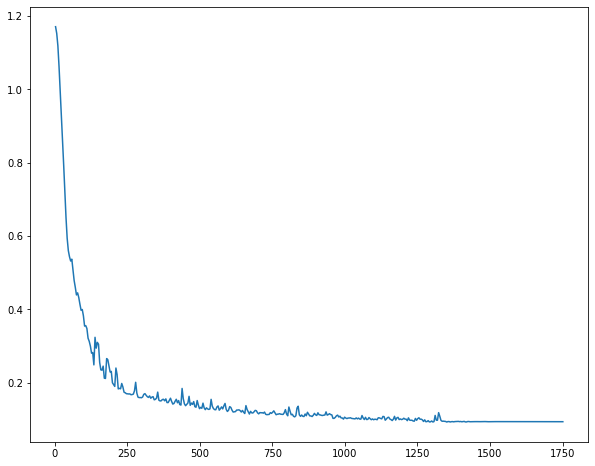

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(step_nums, values_valLoss)

In [20]:
bestModel_byType = df_model.loc[df_model.groupby('input_type').best_val_loss_epoch.idxmin()].reset_index(drop=True)
bestModel_byType

,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506


# Sanity check: best models mean prediction on validation patches

In [21]:
nCenters_dict = {'in56':4, 'in84':2}

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

dice1_test_bestModels = []

for i, row in bestModel_byType.iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    paths_valData, paths_valTarget = setup.get_paths(val_tomos, input_type)
    
    dice1_score = []
    
    scores_tomo10 = []
    scores_tomo32 = []

    for tomo_file, label_file in zip(paths_valData, paths_valTarget):
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file,
                                                                                          label_file, overwrite_prediction=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
        if val==0:
            print('Zero dice1 prediction for: \n', row['model_file'], tomo_file)
            print(dice1_dict)
        elif np.isnan(val):
            print('Undefined dice1 prediction for: \n', row['model_file'], tomo_file)
            print(dice1_dict)
            # make_comparison_plot(class1_predDict, class1, tomogram_data)
        
        if tomo_file.split('/')[-1][0:6] == 'tomo10':
            scores_tomo10.append(val)
        else:
            scores_tomo32.append(val)
    
    print(input_type)
    print('Mean dice1 score on tomo10 patches is: %.6f' %np.nanmean(scores_tomo10))
    print('Mean dice1 score on tomo32 patches is: %.6f \n\n' %np.nanmean(scores_tomo32))
    
    # print('Model predictions on test set patches: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model /home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/patch_creation/result/Task511_cryoET/imagesTr/tomo10_patch030_0000.nii.gz
{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9819, 0.0000], device='cuda:0')}
Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model /home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/patch_creation/result/Task511_cryoET/imagesTr/tomo32_patch030_0000.nii.gz
{'train02-03-17/Baseline_ep1000_in84_lr0.000100_1': tensor([1.0000, 0.0000], device='cuda:0')}
Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cr

In [23]:
dice1_test_bestModels

[0.7672759106284693]

# Get best models mean prediction on test patches

In [20]:
nCenters_dict = {'in56':4, 'in84':2}

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

dice1_test_bestModels = []

for i, row in bestModel_byType.iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    paths_testData, paths_testTarget = setup.get_paths(test_tomos, input_type)
    
    dice1_score = []
    
    scores_tomo04 = []
    scores_tomo38 = []

    for tomo_file, label_file in zip(paths_testData, paths_testTarget):
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file,
                                                                                          label_file, overwrite_prediction=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
        if val==0:
            print('Zero dice1 prediction for: \n', row['model_file'], tomo_file)
            print(dice1_dict)
        elif np.isnan(val):
            print('Undefined dice1 prediction for: \n', row['model_file'], tomo_file)
            print(dice1_dict)
            # make_comparison_plot(class1_predDict, class1, tomogram_data)
        
        if tomo_file.split('/')[-1][0:6] == 'tomo04':
            scores_tomo04.append(val)
        else:
            scores_tomo38.append(val)
    
    print(input_type)
    print('Mean dice1 score on tomo04 patches is: %.6f' %np.nanmean(scores_tomo04))
    print('Mean dice1 score on tomo38 patches is: %.6f \n\n' %np.nanmean(scores_tomo38))
    
    # print('Model predictions on test set patches: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE/train02-03-17/version_2/Baseline_ep1000_in56_lr0.000100_2.model /home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/imagesTr/tomo04_patch030_0000.nii.gz
{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9877, 0.0000], device='cuda:0')}
Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE/train02-03-17/version_2/Baseline_ep1000_in56_lr0.000100_2.model /home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/imagesTr/tomo38_patch030_0000.nii.gz
{'train02-03-17/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9967, 0.0000], device='cuda:0')}
cryoCARE
Mean dice1 score on tomo04 patches is: 0.836848
Mean dice1 score on tomo38 patches is: 0.839154 


Zero dice1 prediction for: 
 /home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train0

In [5]:
bestModel_byType['dice1_test_patches'] = dice1_test_bestModels
bestModel_byType

,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice,dice1_test_patches
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435,0.838001
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506,0.818593
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,isoNET,472 out of 1000,in84,lr0.000100,v1,0.177506,0.840685,0.830425
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816,0.811864


# Analysis of when dice1 score equals zero or nan

In [5]:
def forward(y_pred, y_true):
    # alpha = torch.Tensor([0.5], device=('cuda' if torch.cuda.is_available() else 'cpu)')
    # the case of α = β = 0.5 the Tversky index simplifies to be the same as the Dice coefficient
    alpha = torch.empty((1), device=('cuda' if torch.cuda.is_available() else 'cpu'))
    alpha[0] = 0.5
    beta = torch.empty((1), device=('cuda' if torch.cuda.is_available() else 'cpu'))
    beta[0] = 0.5

    # only classes 0 and 1 are taken into account for the loss      
    batch_size, _, z_shp = y_true.shape 

    mask = y_true[:, 2, :]!=1
    mask = mask.reshape(batch_size, 1, z_shp)
    mask = torch.stack(2*[mask], dim=1).squeeze(2)*1

    # we set all the coordinates labelled as 2 to zero for the loss
    y_true = y_true[:, 0:2, :]*mask
    y_pred = y_pred[:, 0:2, :]*mask

    ones = torch.ones_like(y_true)
    p0 = y_pred
    p1 = (ones - y_pred)
    g0 = y_true
    g1 = (ones - y_true)

    num = torch.sum(p0 * g0, dim=(0, 2)) # shape of inputs are (batch_size, N_class, Z, Y, X)
    den = num.cuda() + alpha.cuda() * torch.sum(p0.cuda() * g1.cuda(), dim=(0, 2)) + beta.cuda() * torch.sum(p1.cuda() * g0.cuda(), dim=(0, 2))

    T = num / den

    return T

In [8]:
y_true = torch.zeros((1, 3, 3))
y_true[0, 0, 0] = 1
y_true[0, 1, 0] = 0
y_true[0, 2, 0] = 0

y_true[0, 0, 1] = 0
y_true[0, 1, 1] = 1
y_true[0, 2, 1] = 0

y_true[0, 0, 2] = 1
y_true[0, 1, 2] = 0
y_true[0, 2, 2] = 0

y_pred = torch.zeros((1, 2, 3))
y_pred[0, 0, 0] = 0
y_pred[0, 1, 0] = 1

y_pred[0, 0, 1] = 1
y_pred[0, 1, 1] = 0

y_pred[0, 0, 2] = 1
y_pred[0, 1, 2] = 0

forward(y_pred.cuda(), y_true.cuda())

tensor([0.5000, 0.0000], device='cuda:0')

Dice score for class 1 is undefined when all pixels corresponding to class 1 predictions are masked out, i.e. true label were noise (2). Or when there are both no class 1 true values nor class 1 predictions.

It is zero when no class 1 pixel was correctly predicted.

# Create gif with predictions with all zero class 1 labels

In [17]:
nCenters_dict = {'in56':4, 'in84':2}

class1_predAll = {}
dice1_scoreAll = {}

# make gif with model predictions tomo04_patch030

for i, row in bestModel_byType.iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    paths_testData, paths_testTarget = setup.get_paths(test_tomos, input_type)
    
    
    
    scores_tomo04 = []
    scores_tomo38 = []
    
    tomo_file = [x for x in paths_testData if 'tomo04_patch030' in x][0]
    label_file = [x for x in paths_testTarget if 'tomo04_patch030' in x][0]

    class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file,
                                                                                      label_file, overwrite_prediction=False)

    val = float(list(dice1_dict.items())[0][1][1])
    old_key = [*class1_predDict][0]
    new_key = old_key.replace('train02-03-17/', input_type+'/')
    class1_predAll[new_key] = class1_predDict[old_key]
    dice1_scoreAll[new_key] = dice1_dict[old_key]
    

In [18]:
dice1_scoreAll

{'cryoCARE/Baseline_ep1000_in56_lr0.000100_2': tensor([0.9877, 0.0000], device='cuda:0'),
 'cryoCARE+isoNET/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9999, 0.0000], device='cuda:0'),
 'isoNET/Baseline_ep1000_in84_lr0.000100_1': tensor([0.9994, 0.0000], device='cuda:0'),
 'rawCET/Baseline_ep1000_in84_lr0.000300_0': tensor([1.0000, 0.0000], device='cuda:0')}

In [24]:
write_comparison_gif(class1_predAll, class1[1, : , : , :].squeeze(), tomogram_data, 'tomo04_patch030_0000')

100%|██████████| 160/160 [01:53<00:00,  1.41it/s]


Removing Images

DONE


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Predict full test tomograms for best models

In [6]:
logs_path = PARENT_PATH + 'models_1/logs/BaselineModel/'
logs_path = Path(logs_path)


tomo_file_cryoCARE = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_bin4_denoised_0000.nii.gz'
tomo_file_rawCET = '/home/haicu/jeronimo.carvajal/Thesis/data/raw_cryo-ET/%s.mrc'
tomo_file_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/RAW_dataset/RAW_corrected_i30/%s_corrected.mrc'
tomo_file_cryoCARE_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc'

tomo_input_type_fileDict = {'rawCET':tomo_file_rawCET,
                            'cryoCARE': tomo_file_cryoCARE,
                            'isoNET': tomo_file_isoNET,
                            'cryoCARE+isoNET': tomo_file_cryoCARE_isoNET}

nCenters_dict = {'in56':28, 'in84':14, 'in96':11}

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

In [13]:
dice1_test_bestModels = []

for i, row in bestModel_byType.iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    
    dice1_score = []

    for tomo in test_tomos:
        tomo_file = tomo_input_type_fileDict[input_type] %tomo
        label_file = aux_label_file %tomo
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, 
                                                                                          label_file, overwrite_prediction=False, is_model_data=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
    print(input_type)
    print('Model predictions on test set: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

cryoCARE
Model predictions on test set: 
 [0.787007212638855, 0.8094673752784729] 


cryoCARE+isoNET
Model predictions on test set: 
 [0.7611339092254639, 0.5529128313064575] 


isoNET
Model predictions on test set: 
 [0.6190276741981506, 0.38708019256591797] 


rawCET
Model predictions on test set: 
 [0.32196739315986633, 0.35235798358917236] 




In [10]:
bestModel_byType['dice1_test_full'] = dice1_test_bestModels
bestModel_byType[['input_type', 'patch_size', 'lr', 'associated_val_class1_dice', 'dice1_test_patches', 'dice1_test_full']].set_index('input_type')

,patch_size,lr,associated_val_class1_dice,dice1_test_patches,dice1_test_full
input_type,,,,,
cryoCARE,in56,lr0.000100,0.883435,0.838001,0.798237
cryoCARE+isoNET,in84,lr0.000100,0.916506,0.818593,0.657023
isoNET,in84,lr0.000100,0.840685,0.830425,0.503054
rawCET,in84,lr0.000300,0.820816,0.811864,0.337163


# Predict full validation tomograms for best models

In [14]:
dice1_test_bestModels = []

for i, row in bestModel_byType.iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    
    dice1_score = []

    for tomo in val_tomos:
        tomo_file = tomo_input_type_fileDict[input_type] %tomo
        label_file = aux_label_file %tomo
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, 
                                                                                          label_file, overwrite_prediction=False, is_model_data=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
    print(input_type)
    print('Model predictions on validation set: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:36<00:00, 70.23it/s]


Predicting full tomogram using 28 centers...


100%|██████████| 10976/10976 [02:36<00:00, 70.19it/s]


cryoCARE
Model predictions on test set: 
 [0.7227136492729187, 0.7298005819320679] 


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.77it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:50<00:00, 26.92it/s]


cryoCARE+isoNET
Model predictions on test set: 
 [0.703208863735199, 0.00033809474552981555] 


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:50<00:00, 26.93it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.78it/s]


isoNET
Model predictions on test set: 
 [0.46878692507743835, 0.41208940744400024] 


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.88it/s]


Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [00:51<00:00, 26.66it/s]


rawCET
Model predictions on test set: 
 [0.24834896624088287, 0.6082371473312378] 




In [15]:
bestModel_byType['dice1_val_full'] = dice1_test_bestModels
bestModel_byType[['input_type', 'patch_size', 'lr', 'associated_val_class1_dice', 'dice1_val_full', 'dice1_test_patches', 'dice1_test_full']].set_index('input_type')

,patch_size,lr,associated_val_class1_dice,dice1_val_full,dice1_test_patches,dice1_test_full
input_type,,,,,,
cryoCARE,in56,lr0.000100,0.883435,0.726257,0.838001,0.798237
cryoCARE+isoNET,in84,lr0.000100,0.916506,0.351773,0.818593,0.657023
isoNET,in84,lr0.000100,0.840685,0.440438,0.830425,0.503054
rawCET,in84,lr0.000300,0.820816,0.428293,0.811864,0.337163


In [16]:
bestModel_byType.to_csv('../data/model_logs/models_1/bestModels_byType_summary.csv', index=False)